In [1]:
%load_ext autoreload
%autoreload 2

**Import**

In [2]:
!pip install liac-arff

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11727 sha256=81aedbd385f878bafaabda8a816d17af0de2ad1c2a7b1eb1b6819f7a2a889c6c
  Stored in directory: c:\users\pc\appdata\local\pip\cache\wheels\cb\9b\84\26c4ed30c02e893caea7e0d9e1bb45e0fb2e06998250c64f5e
Successfully built liac-arff


In [2]:
import os
import time
import numpy as np

# torch
import torch
import torch.nn as nn
import arff

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import f1_score

# spen
from src.multilabel_classification.feature_network import FeatureNetwork
from src.multilabel_classification.spen_multilabel import SPENClassification
from src.multilabel_classification.utils import (
    PATH_MODELS_ML_BIB, PATH_BIBTEX, train_for_num_epochs
)
from utils_data import get_bibtex, load_data_loader
from src.multilabel_classification.feature_network import FILE_FEATURE_NETWORK

# Practical Session on Structured Prediction

This practical session is divided in two parts, each one being dedicated to a structured prediction algorithm.

- Part 1. Input output kernel regression method (IOKR)
- Part 2. Structured prediction energy network (SPEN)

**References**

[1] Belanger, David, and Andrew McCallum. "Structured prediction energy networks." International Conference on Machine Learning. PMLR, 2016.

[2] Brouard, Céline, Marie Szafranski, and Florence d'Alché-Buc. "Input output kernel regression: Supervised and semi-supervised structured output prediction with operator-valued kernels." Journal of Machine Learning Research 17 (2016).

[3] Tsochantaridis, Ioannis, et al. "Support vector machine learning for interdependent and structured output spaces." Proceedings of the twenty-first international conference on Machine learning. 2004.

[4] Katakis, Ioannis, Grigorios Tsoumakas, and Ioannis Vlahavas. "Multilabel text classification for automated tag suggestion." Proceedings of the ECML/PKDD. Vol. 18. 2008.

## Structured prediction

Recall that in structured prediction the goal is to learn a map $f: \mathcal{X} \rightarrow \mathcal{Y}$ from an input space $\mathcal{X}$ to an output space $\mathcal{Y}$, thanks to a finite set of training points $(x_i, y_i)_{i=1}^n$, that minimizes the following risk

$$\mathbb{E}_{\rho}[l(f(x), y)]$$

for a given loss $l(\hat y, y)$ defining the discrepancy between a predicted output $\hat y $ and a true output $y$, and $\rho$ is an unknown distribution on $\mathcal{X} \times \mathcal{Y}$. In structured prediction we consider **complex output** spaces $\mathcal{Y}$.

## Bibtex dataset

You are going to test the two structured prediction methods above on the the bibtex dataset. This is a standard dataset in multi-label classification. Multi-label classification can be seen as a particular instance of structured prediction where $\mathcal{Y} \subset \{0,1\}^d$.

Bibtex is a tag recommendation problem, in which the objective is to propose a relevant set of tags (e.g. url, description, journal volume) to users when they add a new Bibtex entry to the social bookmarking system Bibsonomy (see [4] for more details).

In [3]:
# Load the bibtex dataset

Y_tr, X_tr, _, _ = get_bibtex(PATH_BIBTEX, use_train=True)
Y_te, X_te, _, _ = get_bibtex(PATH_BIBTEX, use_train=False)
n_tr = X_tr.shape[0]
n_te = X_te.shape[0]
input_dim = X_tr.shape[1]
label_dim = Y_tr.shape[1]

print(f'Train set size = {n_tr}')
print(f'Test set size = {n_te}')
print(f'Input dim. = {input_dim}')
print(f'Output dim. = {label_dim}')

Train set size = 4880
Test set size = 2515
Input dim. = 1836
Output dim. = 159


**Definition (f1 score).** In this practical session we will evaluate the performances using the f1 score. In multilabel classification there are several ways to define this score. We will use the one corresponding to the sklearn function sklearn.metrics.f1_score(y, y', average="samples").

The best f1 scores which have been obtained on the Bibtex dataset are around 40%.

## I. IOKR for Structured Prediction

***

In this section, you are going to implement and test an elegant method for structured prediction called **Input Output Kernel Regression (IOKR)**. This method belongs to the family of surrogate methods for structured prediction (cf. lectures).

**Kernel methods (quick reminder).** A kernel over a space $\mathcal{Z}$ is a map $k : \mathcal{Z} \times \mathcal{Z} \rightarrow \mathbb{R}$ that can be written:

$$k(z, z') = \langle \phi(z),\, \phi(z')\rangle_{\mathcal{G}}$$

where $\mathcal{G}$ is a Hilbert space and $\phi: \mathcal{Z} \rightarrow \mathcal{G}$ a map. Hence, $k$ define a similarity between any couple of points in $\mathcal{Z}$. 

**Two examples of kernel.**

The most simple example of kernel is the linear kernel $k(z, z') = \langle z,\, z'\rangle_{\mathcal{Z}}$. So $\phi(x) = x$.

Another famous kernel is the gaussian kernel, defined, for a given $\sigma^2 >0$ by: $k(z, z') = \exp(-\frac{\|z-z\|^2}{2\sigma^2})$. Here there also exists a $\phi$ verifying the kernel definition above, but with valued in an infinite dimensional space! This is not an issue as we never need to explicitely compute any $\phi(x)$ (see below).

**Description of the method.** Consider that we are given two kernels, one over the input and another over the output space.

$$k_x(x,x') = \langle \phi(x),\, \phi(x')\rangle_{\mathcal{G}}$$

$$k_y(y,y') = \langle \psi(y),\, \psi(y')\rangle_{\mathcal{H}}$$ 

The IOKR method for structured prediction can be described in two steps:

- 1/Learning step. Learn the linear map $W : \mathcal{G} \times \mathcal{H}$ thanks to

$$\min_{W} \sum_{i=1}^n \|W\phi(x_i) - \psi(y_i)\|^2_{\mathcal{H}_y} + \lambda \|W\|^2_{F}$$

- 2/Testing step. For a given new inputs $x$ predict $\hat f(x) = \text{argmax}_{y \in \mathcal{Y}}\; \langle \psi(y),\,\hat W\phi(x) \rangle_{\mathcal{H}}$

Observe that the predictor $\hat f: \mathcal{X} \rightarrow \mathcal{Y}$ is non-linear w.r.t $x$ and also $y$.

**Algorithm.** Finally, one can derive a closed-form formula for $\hat f : \mathcal{X} \rightarrow \mathcal{Y}$ defined above. Here we do not ask you to derive this formula but we give it to you:

\begin{equation}
\hat f(x) = \text{argmax}_{y \in \mathcal{Y}} \; \alpha_x(x)^T M \alpha_y(y)
\end{equation}

with $\alpha_x(x) = \left(k_x(x, x_1), \dots, k_x(x, x_n)\right) \in \mathbb{R}^{n}$, $\alpha_y(y) = \left(k_y(y, y_1), \dots, k_y(y, y_n)\right) \in \mathbb{R}^{n}$, $K_x = \left(k_x(x_i, x_j)\right)_{i,j} \in \mathbb{R}^{n \times n}$, and $M = \left( K_x + \lambda I_{\mathbb{R}^n} \right)^{-1} \in \mathbb{R}^{n \times n}$.

![](img/IOKR.png)

**Remark (link with operator-valued kernel).** The IOKR approach is illustrated on the figure above. Observe that we perform a linear regression from $\mathcal{G}$ to $\mathcal{H}$, which can be both infinite dimensional spaces (called reproducing kernel Hilbert space) when $\phi$ and $\psi$ are defined with the non linear gaussian kernel. Moreover, notice also, that the approach corresponds to a vector-valued kernel regression from $\mathcal{X}$ to $\mathcal{H}$. This situation can be interpreted through the use of an operator-valued kernel (ovk). Here we use the ovk defined by $\tilde k_x(x,x') =  k_x(x,x') I_{\mathcal{H}}$, where $I_{\mathcal{H}}$ denotes the identity operator of $\mathcal{H}$.

***


#### Question 1. (decoding) 
During the decoding step, for a given input $x$ one needs to compute the scores $s(x,y) = \alpha_x(x)^T M \alpha_y(y)$ for all $y \in \mathcal{Y}$ in order to predict $y$ with the maximum $s(x,y)$. Considering all the $\{0,1\}^{159}$ possible 0-1 vectors is too costly. Hence, here we consider only points in the training set Y_tr as possible candidates.

Show that, for any test set X_te of size $n_{te}$, you can compute all the $n \times n_{te}$ scores, by only making matrix multiplications of the three following matrices: $M \in \mathbb{R}^{n \times n}$ (defined above), $K_x = \left(k_x(x_i, x_j)\right)_{i,j} \in \mathbb{R}^{n \times n_{te}}$, and $K_y = \left(k_y(y_i, y_j)\right)_{i,j} \in \mathbb{R}^{n \times n}$.

Answer 1:
We want to compute $s(x_j,y_k) = \alpha_x(x_j)^T M \alpha_y(y_k)$ for all $x_j \in X_{te}$ and all $y_k \in Y_{tr}$, we notice that 
$$\alpha_x(x_j) = \left(k_x(x_j, x_1), \dots, k_x(x_j, x_n)\right) = (K_x(x_j,x_i))^T_{x_i \in X_{tr}}$$
is actually the j-th row of $K_x^T$ defined in question 1.
Meanwhile
$$\alpha_y(y_k) = \left(k_y(y_k, y_1), \dots, k_y(y_k, y_n)\right) = (K_y(y_k,y_i))_{y_i \in {Y_{tr}}}$$
is actually the k-th column of $K_y$ defined in question 1.

Therefore if we let $x_j, y_k$ running over $X_{te}$ and $Y_{tr}$, we will get a matrix:

$$(s(x_j,y_k))_{x_j \in X_{te}, y_k \in Y_{tr}} = (K_x^T(x_i,x_j) M K_y(y_k,y_i))_{x_j,y_k} = K_x^T M K_y$$

#### Question 2. (implementation)
Implement the method IOKR using gaussian input and output kernels, with parameters $\sigma_x^2, \sigma_y^2 >0$ respectively. Define a python class with a method fit(X_tr, Y_tr, lambda, sigmax, sigmay), and a method predict(X_te). Use the rbf_kernel python function loaded above to compute the gram matrices $K_x, K_y$. 

In [ ]:
# Implementation

from typing import Optional


class IOKR:
    
    def __init__(self, is_linear=False):
        self.X_tr = None
        self.Y_tr = None
        self.Ky = None
        self.sy = None
        self.M = None
        self.verbose = 0
        self.linear = is_linear
        
    def fit(self, X, Y, L:float, sx:float, sy: Optional[float]):
        self.X_tr = X
        self.Y_tr = Y
        self.sx = sx
        self.sy = sy
        Kx = rbf_kernel(self.X_tr, self.X_tr, 1/(2*sx**2))
        if self.linear:
            self.Ky = self.Y_tr @ self.Y_tr.T
        else:
            self.Ky = rbf_kernel(self.Y_tr, self.Y_tr, 1/(2*sy**2))
        self.M = np.linalg.inv((Kx + L * np.identity(Kx.shape[0])))
    
    def predict(self, X_te):
        Kx = rbf_kernel(X_te, self.X_tr, 1/(2*self.sx**2)) 
        score = Kx @ self.M @ self.Ky
        assert score.shape == (X_te.shape[0], self.Y_tr.shape[0])
        index = np.argmax(score, axis=1)
        return self.Y_tr[index]

#### Question 3. (sanity check)
Verify that your algorithm is able to learn a predictor that overfits the training set, i.e. such that the f1 score on the train set is close to $1$. For instance, plot the train f1 score w.r.t $\lambda$ (for $s_x, s_y$ big enough).

In [72]:
iokr_predictor = IOKR()
iokr_predictor.fit(X_tr, Y_tr, L=0.1, sx=1, sy=1)

In [73]:
y_pred = iokr_predictor.predict(X_tr)

In [74]:
print(f1_score(Y_tr, y_pred, average='samples'))

0.9982887467723532


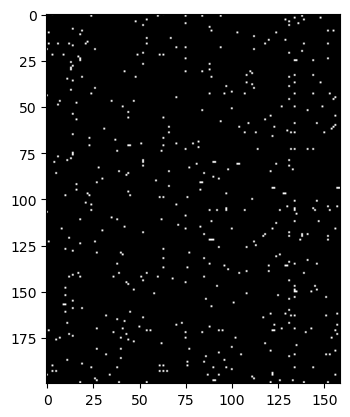

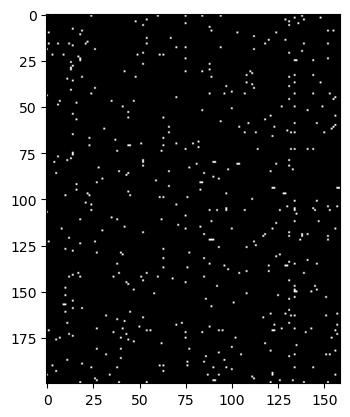

In [75]:
import matplotlib.pyplot as plt
plt.imshow(Y_tr[:200], cmap='gray')
plt.figure()
plt.imshow(y_pred[:200], cmap='gray')

In [78]:
iokr_predictor = IOKR()
L = [1, 1e-1, 1e-2, 1e-3, 1e-4]
F1_scores = []
for l in L:
	print(f'L={l}')
	iokr_predictor.fit(X_tr, Y_tr, L=l, sx=1, sy=1)
	y_pred_tr = iokr_predictor.predict(X_tr)
	F1_scores.append(f1_score(Y_tr, y_pred_tr, average='samples'))

L=1
L=0.1
L=0.01
L=0.001
L=0.0001


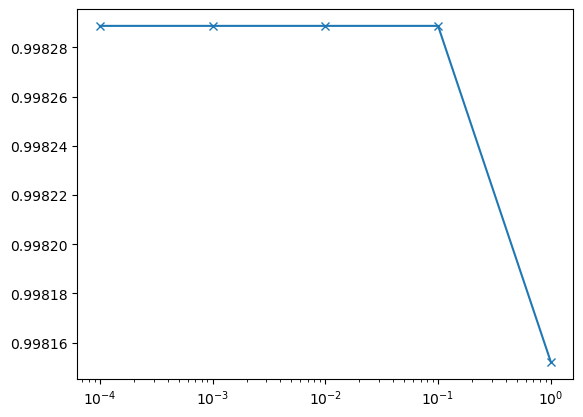

In [84]:
plt.plot(L, F1_scores, marker='x')
plt.xscale('log')

#### Question 4. (hyperparameters selection)

We would like to assess the performance of IOKR on the bibtex dataset.

In order to select the hyperparameters $\lambda, \sigma_x^2, \sigma_y^2$, proceed as follows. For a given tuples of parameters, train with $\frac{4}{5}$ of the train set, and then compute the f1 score (called validation score) on the remaining $\frac{1}{5}$ of the train set (called validation set). By repeating this over a grid of hyperparameters select the best tuples with the highest validation score.

Explain the role of the validation set. Why it is extracted from the train set? Then, compute the test f1 score on the test set, using the best selected parameters.

Answer 4: The role of the validation set is to do model selection, i.e. to find the hyperparameter of the model that has best generality on unseen data. Therefore, we extract it from the train set to ensure the model doesn't know it and use them as a validation of the model performance (since they are labeled).

In [111]:
from itertools import product
from typing import List
import pandas as pd
from tqdm import tqdm

def KFold_score(sx, sy, l):
	kf = KFold(5, shuffle=False)
	f1_scores = []
	for i, (idx_train, idx_val) in enumerate(kf.split(X_tr)):
		X_train = X_tr[idx_train]
		X_val = X_tr[idx_val]
		Y_train = Y_tr[idx_train]
		Y_val = Y_tr[idx_val]
		iokr_predictor.fit(X_train, Y_train, L=l, sx=sx, sy=sy)
		# print(len(idx_train))
		# print(len(idx_val))
		y_val_pred = iokr_predictor.predict(X_val)
		f1 = f1_score(Y_val, y_val_pred, average='samples')
		f1_scores.append(f1) 
		return np.mean(f1_scores)


def grid_search(sigma_x:List[float], sigma_y:List[float], L:List[float]):
	records = []
	for sx, sy, l in tqdm(product(sigma_x, sigma_y, L), total=len(sigma_x)*len(sigma_y)*len(L)):
		f1_score = KFold_score(sx, sy, l)
		records.append({'sx': sx, 'sy': sy, 'l': l, 'f1_score': f1_score})
	grid = pd.DataFrame.from_records(records)
	return grid

In [113]:
grid = grid_search([1, 1e-1, 1e-2, 1e-3],[1, 1e-1, 1e-2, 1e-3],[1, 1e-1, 1e-2, 1e-3])

100%|██████████| 64/64 [07:09<00:00,  6.71s/it]


In [114]:
grid.to_csv('grid.csv')

In [119]:
grid.iloc[grid['f1_score'].idxmax()]

sx          1.000000
sy          1.000000
l           0.100000
f1_score    0.230706
Name: 1, dtype: float64

In [120]:
grid2 = grid_search([1, 5, 10],[1, 5, 10],[1, 0.1, 0.01])

100%|██████████| 27/27 [02:15<00:00,  5.02s/it]


In [121]:
grid2.to_csv('grid2.csv')

In [123]:
grid2.iloc[grid2['f1_score'].idxmax()]

sx          10.000000
sy           1.000000
l            0.100000
f1_score     0.440631
Name: 19, dtype: float64

In [143]:
grid3 = grid_search([10, 11, 12],[0.8, 0.9, 1],[0.09, 0.1, 0.11])

100%|██████████| 27/27 [02:05<00:00,  4.65s/it]


In [144]:
grid3.to_csv('grid3.csv')

In [145]:
grid3.iloc[grid3['f1_score'].idxmax()]

sx          10.000000
sy           0.900000
l            0.090000
f1_score     0.445343
Name: 3, dtype: float64

In [147]:
iokr_predictor.fit(X_tr, Y_tr, 0.09, 11, 0.9)
y_pred_te = iokr_predictor.predict(X_te)
print(f1_score(Y_te, y_pred_te, average='samples'))

0.45665049238137023


Answer 4 continued: with careful hyperparameter sweeping, we find $\sigma_x = 11, \sigma_y = 0.9, \lambda=0.09$, with such configuration the test f1 score is 0.4567

#### Question 5. (linear vs non linear)

Modify your code such that you can use IOKR with an output linear kernel $k_y(y,y') = \langle y, y' \rangle_{\mathbb{R}^d}$. Then, compare the performance of the linear and the gaussian (output) kernels on the bibtex dataset. For this purpose, you need to select the hyper-parameters ($\lambda, \sigma_x^2$ in the case of the linear output kernel, and $\lambda, \sigma_x^2, \sigma_y^2$ for the gaussian kernel).

In [150]:
iokr_predictor = IOKR(is_linear=True)

In [153]:
grid4 = grid_search([10, 1, 1e-1], [None], [10, 1e-1, 1e-2])

100%|██████████| 9/9 [01:25<00:00,  9.55s/it]


In [154]:
grid4.to_csv('grid4.csv')

In [155]:
grid4.iloc[grid4['f1_score'].idxmax()]

sx              10.0
sy              None
l                0.1
f1_score    0.304209
Name: 1, dtype: object

In [156]:
grid4

,sx,sy,l,f1_score
0,10.0,None,10.00,0.150733
1,10.0,None,0.10,0.304209
2,10.0,None,0.01,0.292076
3,1.0,None,10.00,0.129498
4,1.0,None,0.10,0.147119
5,1.0,None,0.01,0.147574
6,0.1,None,10.00,0.057670
7,0.1,None,0.10,0.057670
8,0.1,None,0.01,0.057670


In [157]:
grid5 = grid_search([9, 10, 11], [None], [0.09, 0.1, 0.11])

100%|██████████| 9/9 [01:21<00:00,  9.04s/it]


In [158]:
grid5.to_csv('grid5.csv')

In [159]:
grid5.iloc[grid5['f1_score'].idxmax()]

sx                 9
sy              None
l                0.1
f1_score    0.305157
Name: 1, dtype: object

In [160]:
grid5

,sx,sy,l,f1_score
0,9,None,0.09,0.304613
1,9,None,0.10,0.305157
2,9,None,0.11,0.304296
3,10,None,0.09,0.303973
4,10,None,0.10,0.304209
5,10,None,0.11,0.304779
6,11,None,0.09,0.302587
7,11,None,0.10,0.302338
8,11,None,0.11,0.302243


In [163]:
iokr_predictor.fit(X_tr, Y_tr, 0.1, 9, None)
y_pred_te = iokr_predictor.predict(X_te)
print(f1_score(Y_te, y_pred_te, average='samples'))

0.3077509805514733


Answer 5: best hyperparameter configuration for linear output kernel is $\sigma_x=9, \lambda=0.1$, test f1 score is 0.3078

#### Question 6. (computational complexity)

What is the complexity in time and space of IOKR (for training and decoding)?

Answer 6:

|complexity| space | time |
|:-:|:-:|:-:|
|training|$O(n^2)$|$O(n_{tr}^2 (n_\text{input dim}+n_\text{label dim}))$|
|decoding|$O(n_e n$)|$O(n_e n^2)$|

## II. Structured prediction energy network (SPEN)

Structured Prediction Energy Networks (SPENs) are deep energy-based models, constituting a flexible framework for structured prediction, in particular multi-label classification.

SPENs tackle multi-label classification, then $\mathcal{Y} = \{0,1\}^L$ with $L \in \mathbb{N}^*$. Thus, for a given input $x$, a SPEN performs prediction by solving the following problem::
$$
    \underset{y}{\operatorname{min}} ~ E_x(y) \quad \text{subject to} \quad y \in \{0,1\}^L, \quad \text{(1)}
$$
where enery function $E_x$ is encoded by a deep architecture.\\
Authors choose to solve an easier problem and optimize over a convex relaxation of the constraint set:
$$
    \underset{\bar{y}}{\operatorname{min}} ~ E_x(\bar{y}) \quad \text{subject to} \quad \bar{y} \in [0,1]^L. \quad \text{(2)}
$$
Optimization over $[0,1]^L$ to obtain a prediction $\bar{y}^* \in [0,1]^L$ can be performed using projected gradient descent or entropic mirror descent. Finally, for an input $x$, prediction $f(x) = (f(x)_1, \ldots, f(x)_L)^\top \in \{0,1\}^L$ is obtained by rounding each coordinate $\bar{y}_i^*$ to $0$ or $1$. Hence, for all $1 \leq i \leq L$:
$$
    f(x)_i = \left\{
            \begin{array}{ll}
                 0 & \text{if } \bar{y}_i^* < 0.5\\
                1 & \text{otherwise.}
            \end{array}
            \right.
$$
Where $\bar{y}^* = \underset{\bar{y} \in [0,1]^L}{\operatorname{argmin}} ~ E_x(\bar{y})$.

A SPEN parameterizes $E_x(\bar{y})$ as a neural network that takes both $x$ and $\bar{y}$ as inputs and returns the energy. It consists of two deep architectures as illustrated in the following image:

- a feature extraction network;
- an energy network.

![A SPEN architecture](img/Spen_architecture.png)

This practical session is divided in two sections:

- A) Learning feature extraction network;
- B) Learning energy network.

We used an implementation of SPEN in python with PyTorch by Philippe Beardsell and Chih-Chao Hsu (cf. https://github.com/philqc/deep-value-networks-pytorch). Small changes have been made.

### A) Feature extraction network

In this section, the goal is to learn the feature extractor part of a SPEN architecture encoded by this deep network:
$$
    F(x) = g(A_2g(A_1x)). \quad \text{(3)}
$$
Hence, by gradient descent and backpropagation we learn the parameters $A_1$ and $A_2$.
This training is performed by adding a third layer (which is used only during training and removed later) with a sigmoid activation function and performing a classification task with a Binary Cross Entropy loss.
The optimizer used can be rather "adam" or "sgd" solver.
The rest of hyperparameters are indicated below.

#### Question 7.  (learning feature extractor network)

Use functions train_feature_extraction and test_feature_extraction to train and test feature extraction network and study the influence of optimisation hyperparameters (learning rate, momentum, batch size and number of epochs).

Answer 7: With a careful hypertuning step, we find that the proper learning rate is $10^{-3}$, neither too big nor too small lr will cause a degradation of performance. Momentum and batch size seems have little influence on the performance. The valid loss stops to decrease after 15 epochs. The best test f1 score we could achieve is around 0.35. 

In [84]:
# optimization solver's parameters
lr = 1e-3
momentum = 10

In [85]:
# Feature extractor network instantiation
f_net = FeatureNetwork(lr=lr, momentum=momentum,
                       optimizer="adam", weight_decay=0,
                       input_dim=input_dim, label_dim=label_dim)

In [86]:
# function for training the feature extractor

def train_feature_extraction(X_tr, Y_tr, X_val, Y_val,
                             f_net: FeatureNetwork,
                             path_save: str, n_epochs: int,
                             batch_size: int,
                             step_size_scheduler: int,
                             norm_inputs=True):
    """
    Trains a feature extractor network
    """
    
    use_cuda = torch.cuda.is_available()
    
    train_loader = load_data_loader(X_tr, Y_tr, use_cuda,
                                    batch_size=batch_size,
                                    norm_inputs=norm_inputs,
                                    shuffle=False)
    
    valid_loader = load_data_loader(X_val, Y_val, use_cuda,
                                    batch_size=batch_size,
                                    norm_inputs=norm_inputs,
                                    shuffle=False)

    scheduler = torch.optim.lr_scheduler.StepLR(
        f_net.optimizer, step_size=step_size_scheduler, gamma=0.1
    )

    loss_train, loss_valid, list_f1_valid = train_for_num_epochs(
        f_net,
        train_loader,
        valid_loader,
        os.path.join(path_save, FILE_FEATURE_NETWORK),
        n_epochs,
        scheduler
    )
    
    return loss_train, loss_valid, list_f1_valid

In [87]:
# Split the training set in train/validation sets

train_valid_ratio=0.8

n_train = int(len(X_tr) * train_valid_ratio)
indices = list(range(len(X_tr)))

x_train, y_train = X_tr[:n_train], Y_tr[:n_train]
x_valid, y_valid = X_tr[n_train:], Y_tr[n_train:]

In [88]:
# Number of epochs and batch size settings

n_epochs = 50
batch_size = 128

Preparing the data loader...
Preparing the data loader...
Epoch 0
Training: [3904 / 3904 (100%)]: Avg_Loss = 52.74844
Avg_Loss = 17.89; F1_Score = 0.00
--- Saving model at F1 = 0.00 ---
Epoch 1
Training: [3904 / 3904 (100%)]: Avg_Loss = 13.89941
Avg_Loss = 11.97; F1_Score = 3.98
--- Saving model at F1 = 3.98 ---
Epoch 2
Training: [3904 / 3904 (100%)]: Avg_Loss = 10.41032
Avg_Loss = 10.20; F1_Score = 14.29
--- Saving model at F1 = 14.29 ---
Epoch 3
Training: [3904 / 3904 (100%)]: Avg_Loss = 9.19918
Avg_Loss = 9.43; F1_Score = 17.77
--- Saving model at F1 = 17.77 ---
Epoch 4
Training: [3904 / 3904 (100%)]: Avg_Loss = 8.44295
Avg_Loss = 8.91; F1_Score = 19.27
--- Saving model at F1 = 19.27 ---
Epoch 5
Training: [3904 / 3904 (100%)]: Avg_Loss = 7.78247
Avg_Loss = 8.46; F1_Score = 20.52
--- Saving model at F1 = 20.52 ---
Epoch 6
Training: [3904 / 3904 (100%)]: Avg_Loss = 7.16810
Avg_Loss = 8.12; F1_Score = 23.21
--- Saving model at F1 = 23.21 ---
Epoch 7
Training: [3904 / 3904 (100%)]: Avg_

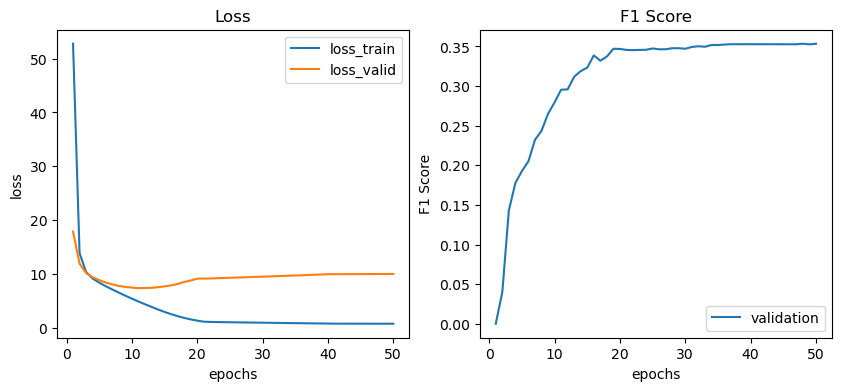

In [89]:
# feature extractor training
loss_train, loss_valid, list_f1_valid = train_feature_extraction(x_train, y_train,
                                                                 x_valid, y_valid,
                                                                 f_net,
                                                                 PATH_MODELS_ML_BIB,
                                                                 n_epochs=n_epochs,
                                                                 batch_size=batch_size,
                                                                 step_size_scheduler=20)

In [90]:
# function for testing the feature extractor

def test_feature_extractor(X_te, Y_te, path_save, f_net):
    """
    Tests a feature extractor network
    """
    use_cuda = torch.cuda.is_available()

    test_loader = load_data_loader(X_te, Y_te, use_cuda)

    print('Computing the F1 Score on the test set...')
    test_loss, test_mean_f1 = f_net.valid(test_loader)
    
    return test_loss, test_mean_f1

In [91]:
# compute the test f1 score of the feature extractor network

test_loss, test_mean_f1 = test_feature_extractor(X_te, Y_te, PATH_MODELS_ML_BIB, f_net)

Preparing the data loader...
Computing the F1 Score on the test set...
Avg_Loss = 10.62; F1_Score = 34.99


### B) Energy network

Now, the goal is to learn the energy network part of a SPEN architecture encoded by this deep network:
$$
    E_x(\bar{y}) = E(F(x),\bar{y}) = E_{x}^{\text {local }}(\bar{y}) + E_{x}^{\text {label }}(\bar{y}) \quad \text{(4)}
$$
where:
$$
    E_{x}^{\text {local }}(\bar{y})=\sum_{i=1}^{L} \bar{y}_{i} b_{i}^{\top} F(x) \quad \text{(5)}
$$
and
$$
    E_{x}^{\text {label }}(\bar{y})=c_{2}^{\top} g\left(C_{1} \bar{y}\right) \quad \text{(6)}
$$
and $F(x)$ is the feature extractor previously trained (with only 2 layers, the third one is now removed as said earlier).
Hence, parameters to learn are $b_i$ s, $C_1$ and $c_2$.

To achieve learning, authors use a structured Hinge loss, similarly to Structured Support Vector Machine (SSVM) (see Lecture 1).

Then, they define $\Delta\left(y_{p}, y_{g}\right)$ to be an error function between a prediction $y_{p}$ and the ground truth $y_{g}$ not dependent on the structured output set, such as the Hamming loss. Let $[\cdot]_{+}=\max (0, \cdot) .$ The SSVM minimizes:
$$
    \sum_{\left\{x_{i}, y_{i}\right\}} \max _{y}\left[\Delta\left(y_{i}, y\right)-E_{x_{i}}(y)+E_{x_{i}}\left(y_{i}\right)\right]_{+}. \quad \text{(7)}
$$
 Learning is performed by minimizing the loss with respect to the parameters of the deep architecture $E_{x}$ using mini-batch stochastic gradient descent. For $\left\{x_{i}, y_{i}\right\}$, computing the subgradient of (7) with respect to the prediction requires loss-augmented inference:
$$
     y_{p}=\underset{y}{\arg \min }\left(-\Delta\left(y_{i}, y\right)+E_{x_{i}}(y)\right). \quad \text{(8)}
$$
With this, the subgradient of (7) with respect to the model parameters is obtained by back-propagation through $E_{x}$.

#### Question 8.  (role of $E_x^{label}$)

What is the role of $E_x^{label}$? Describe briefly its specificity and difference from $E_x^{local}$.

Answer *: In the figure, $E_x^{\text{label}}$ is called the global energy term contains only the $\bar{y}$, which can be regarded as a regularization term penalizing a particular configuration of $\bar{y}$. While the local energy term $E_x^{\text{local}}$ is a loss that measures the correlation between the extracted feature and the labels.

#### Question 9.  (learning energy network)

Once the feature extraction network is trained, use functions train_energy_network and test_energy_network to train and test energy network and study the influence of :

- The size of $c_2$: num_pairwise.
- optimisation hyperparameters for network learning (optimisation part associated to learning $b_i$ s, $C_1$ and $c_2$): learning rate, momentum, batch size and number of epochs;
- optimisation hyperparameters for inference (computation of $\bar y$): learning rate and momentum.

In [92]:
# optimization solver's parameters
learning_rate = 1e-5
momentum = 0.90

In [93]:
# Optimisation hyperparameters for loss-augmented inference
inf_lr = 0.1
momentum_inf = 0.95

In [94]:
# num_pairwise x dim label
num_pairwise = 16

In [110]:
# Energy network instantiation

feature_extractor_file = "saved_results/bibtex/feature_network.pth"

spen = SPENClassification(feature_extractor_file, # Loading feature extractor trained earlier
                          loss_fn="mse",
                          input_dim=input_dim,
                          label_dim=label_dim,
                          optim="adam",
                          learning_rate=learning_rate,
                          momentum=momentum,
                          non_linearity=nn.Softplus(),
                          num_pairwise=num_pairwise
                         )

Using Mean Squared Error Loss


In [111]:
spen.device

device(type='cuda')

In [ ]:
# function for training SPEN

def train_energy_network(X_tr, Y_tr, X_val, Y_val,
                         path_save, spen,
                         n_epochs=10, batch_size=32,
                         norm_inputs=True):
    """
    Trains an energy network
    """
    use_cuda = torch.cuda.is_available()

    train_loader = load_data_loader(X_tr, Y_tr, use_cuda,
                                    batch_size=batch_size,
                                    norm_inputs=norm_inputs,
                                    shuffle=False)
    
    valid_loader = load_data_loader(X_val, Y_val, use_cuda,
                                    batch_size=batch_size,
                                    norm_inputs=norm_inputs,
                                    shuffle=False)

    input_dim = X_tr.shape[1]
    label_dim = Y_tr.shape[1]

    name = 'spen_bibtex'
    path_save_model = os.path.join(path_save, name + '.pth')

    scheduler = torch.optim.lr_scheduler.StepLR(spen.optimizer, step_size=10, gamma=0.1)
    n_epochs = n_epochs

    loss_train, loss_valid, list_f1_valid = train_for_num_epochs(spen,
                                                                 train_loader,
                                                                 valid_loader,
                                                                 path_save_model,
                                                                 n_epochs,
                                                                 scheduler)
    
    return loss_train, loss_valid, list_f1_valid

In [105]:
# Number of epochs and batch size settings

n_epochs = 10
batch_size = 32

In [106]:
# SPEN training

loss_train, loss_valid, list_f1_valid = train_energy_network(x_train, y_train,
                                                             x_valid, y_valid,
                                                             PATH_MODELS_ML_BIB,
                                                             spen, n_epochs=n_epochs,
                                                             batch_size=batch_size,
                                                             norm_inputs=True)

Preparing the data loader...
Preparing the data loader...
Epoch 0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
# function for testing SPEN

def test_energy_network(X_te, Y_te, path_save, spen):
    """
    Tests an energy network
    """
    use_cuda = torch.cuda.is_available()

    test_loader = load_data_loader(X_te, Y_te, use_cuda)

    print('Computing the F1 Score on the test set...')
    test_loss, test_mean_f1 = spen.valid(test_loader)
    
    return test_loss, test_mean_f1

In [ ]:
# Test of SPEN on the test set

test_loss, test_mean_f1 = test_energy_network(X_te, Y_te, PATH_MODELS_ML_BIB, spen)

#### Question 10.  ( structured network)

Is the structured part of the SPEN's model $E^{label}_x$ useful with the Bibtex dataset? What can you conclude? 